# Week 4 - Part 2: High Frequency Words

Alice Ding, Shoshana Farber, Christian Uriostegui

### Assignment Details:

1. Choose a corpus of interest.
2. How many unique words are in the corpus?
3. Taking the most common words, how many unique words represent half the total words in the corpus?
4. Identify the 200 highest frequency words in this corpus.
5. Create a graph that shows the relative frequency of these 200 words.
6. Does the observed relative frequency of these words follow Zipf's law? Explain.
7. In what ways do you think the frequency of the words in this corpus differ from "all words in corpora?"

### Corpus of Interest

For this assignment, we chose to use the script for the first Captain America movie. The `.txt` file for the script was found on Kaggle and can be accessed [here](https://www.kaggle.com/datasets/pdunton/marvel-cinematic-universe-dialogue). 

***

### Loading the Text File

In [97]:
import nltk
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
import requests

url = "https://raw.githubusercontent.com/ShanaFarber/cuny-data620/main/week4_part2/captain_america.txt"

script = requests.get(url).content

script = script.decode()

In [100]:
lines = script.split('\n')

In [101]:
# preview first few lines
lines[:15]

['[first lines; in the Arctic]',
 'Search Team Leader: Are you the guys from Washington?',
 'SHIELD Tech: You get many other visitors out here?',
 'SHIELD Lieutenant: How long have you been on site?',
 'Search Team Leader: Since this morning. A Russian oil team called it in about 18 hours ago.',
 'SHIELD Lieutenant: How come nobody spotted it before?',
 'Search Team Leader: It’s really not that surprising. This landscape’s changing all the time. You got any ideas what this thing is exactly?',
 'SHIELD Lieutenant: I don’t know. It’s probably a weather balloon.',
 'Search Team Leader: I don’t think so. You know we don’t have the equipment for a job like this.',
 'SHIELD Tech: How long before we can start craning it out?',
 'Search Team Leader: I don’t think you quite understand. You guys are gonna need one hell of a crane!',
 '[as the shot widens we see a massive frozen ship revealed]',
 '[after breaking into the metal aircraft]',
 'SHIELD Lieutenant: [speaking into his comm] Base, we’re


For the word analysis, we don't need the descriptions in brackets and we don't need the names of the characters, just the dialogue. 

First, let's remove the bracketed descriptions.

In [106]:
# function to remove bracketed words and some special characters
def clean_line(line):
    new_line = re.sub('\[.*\]', '', line)
    new_line = re.sub('’', '\'', new_line)
    new_line = re.sub('…', ' ', new_line)
    new_line += '\n'
    return(new_line)

# initiate list of cleaned lines
cleaned_lines = []

# use function to remove bracketed lines
# only include lines that are not empty
for line in lines:
    line = clean_line(line)
    if not line.startswith('\n'):
        cleaned_lines.append(line)

cleaned_lines[:15]

['Search Team Leader: Are you the guys from Washington?\n',
 'SHIELD Tech: You get many other visitors out here?\n',
 'SHIELD Lieutenant: How long have you been on site?\n',
 'Search Team Leader: Since this morning. A Russian oil team called it in about 18 hours ago.\n',
 'SHIELD Lieutenant: How come nobody spotted it before?\n',
 "Search Team Leader: It's really not that surprising. This landscape's changing all the time. You got any ideas what this thing is exactly?\n",
 "SHIELD Lieutenant: I don't know. It's probably a weather balloon.\n",
 "Search Team Leader: I don't think so. You know we don't have the equipment for a job like this.\n",
 'SHIELD Tech: How long before we can start craning it out?\n',
 "Search Team Leader: I don't think you quite understand. You guys are gonna need one hell of a crane!\n",
 'SHIELD Lieutenant:  Careful.\n',
 'SHIELD Tech:  Lieutenant! What is it?\n',
 'SHIELD Lieutenant: My God!  Base, give me a line to the Colonel.\n',
 "Voice from Earpiece: It's 

Now we can also remove character names before each line. In order to preserve knowledge of whose line is whose, let's create a dataframe of the script with a column for character and a column for the line they say.

In [107]:
# function to split line on :
# each line in form of character: dialogue
def split_line(line):
    split_line = re.sub('\n', '', line).split(': ')
    return(split_line)

# initilize empty list
split_lines = []

# create list of split lines
for line in cleaned_lines:
    line = split_line(line)
    split_lines.append(line)

split_lines[:15]

[['Search Team Leader', 'Are you the guys from Washington?'],
 ['SHIELD Tech', 'You get many other visitors out here?'],
 ['SHIELD Lieutenant', 'How long have you been on site?'],
 ['Search Team Leader',
  'Since this morning. A Russian oil team called it in about 18 hours ago.'],
 ['SHIELD Lieutenant', 'How come nobody spotted it before?'],
 ['Search Team Leader',
  "It's really not that surprising. This landscape's changing all the time. You got any ideas what this thing is exactly?"],
 ['SHIELD Lieutenant', "I don't know. It's probably a weather balloon."],
 ['Search Team Leader',
  "I don't think so. You know we don't have the equipment for a job like this."],
 ['SHIELD Tech', 'How long before we can start craning it out?'],
 ['Search Team Leader',
  "I don't think you quite understand. You guys are gonna need one hell of a crane!"],
 ['SHIELD Lieutenant', ' Careful.'],
 ['SHIELD Tech', ' Lieutenant! What is it?'],
 ['SHIELD Lieutenant', 'My God!  Base, give me a line to the Colone

In [108]:
# turn split lines into data frame
dialogue_df = pd.DataFrame(split_lines, columns = ['character', 'line']).dropna()

dialogue_df.head()

,character,line
0,Search Team Leader,Are you the guys from Washington?
1,SHIELD Tech,You get many other visitors out here?
2,SHIELD Lieutenant,How long have you been on site?
3,Search Team Leader,Since this morning. A Russian oil team called ...
4,SHIELD Lieutenant,How come nobody spotted it before?


We can now tokenize the words from the dialogue. 

First, we will concatenate all the dialogue into a single string. 

In [109]:
dialogue = ''

for line in dialogue_df['line']:
    dialogue += line.lower() + " "

With **NLTK** library, we can use the `word_tokenize()` function to tokenize text. However, this splits words with apostrophe, so for this text we will use `TweetTokenizer.tokenize()` from **NLTK** to tokenize the words without splitting on the apostrophe.

In [110]:
tokenized_dialogue = nltk.TweetTokenizer().tokenize(dialogue)

print(tokenized_dialogue[:15])

['are', 'you', 'the', 'guys', 'from', 'washington', '?', 'you', 'get', 'many', 'other', 'visitors', 'out', 'here', '?']


Let's remove the punctuation, as these are not words. We can get a list of punctuation from the **string** library. 

In [111]:
# get punctuation symbols
from string import punctuation
punct = list(punctuation)

# create list of unique tokenized words
tokenized_dialogue = [token for token in tokenized_dialogue if token not in punct]

Now that the words are tokenized, we can now answer the questions from the assignment prompt. 

***

**How many unique words are there in the corpus?**

We can use a for loop to create a list of all the unique words in the corpus. 

In [112]:
# initialize list
unique_words = []

# check if word already present, otherwise append to unique list
for word in tokenized_dialogue:
    if word not in unique_words:
        unique_words.append(word)

print(unique_words[:15])

['are', 'you', 'the', 'guys', 'from', 'washington', 'get', 'many', 'other', 'visitors', 'out', 'here', 'how', 'long', 'have']


In [113]:
print("There are", str(len(unique_words)), "unique words in this corpus.")

There are 1624 unique words in this corpus.


***

**Taking the most common words, how many unique words represent half the total words in the corpus?**

First, let's determine how many words would make up half the corpus.

In [114]:
print("There are", str(len(tokenized_dialogue)), "total words in this corpus.", str(len(tokenized_dialogue)/2), "words would make up half the corpus.")

There are 6835 total words in this corpus. 3417.5 words would make up half the corpus.


Now let's count how often each unique word appears in the script and sort by descending count. We can use **NLTK**'s `FreqDist()` function to calculate the frequencies for each word and `most_common()` to order by descending count.

In [121]:
unique_word_count = nltk.FreqDist(tokenized_dialogue).most_common()

[('you', 266), ('the', 244), ('i', 192), ('a', 167), ('to', 135), ('of', 99), ('it', 94), ('is', 88), ('and', 80), ('that', 78), ('this', 73), ('in', 73), ('what', 68), ('are', 65), ('on', 57), ('we', 55), ('your', 54), ('do', 53), ('not', 52), ("don't", 49), ('for', 49), ('me', 45), ('know', 44), ('but', 42), ('have', 41), ("i'm", 40), ('all', 38), ('be', 38), ("it's", 37), ('he', 36), ('my', 35), ('no', 35), ('get', 34), ('just', 34), ('can', 33), ('with', 33), ('about', 31), ("you're", 30), ('how', 29), ('think', 29), ('will', 29), ('one', 28), ('got', 27), ('so', 27), ('him', 25), ('up', 25), ('here', 24), ('they', 24), ('come', 23), ('like', 22), ('there', 22), ('if', 21), ('more', 21), ("he's", 21), ('captain', 21), ('was', 20), ('right', 20), ("that's", 20), ('hydra', 20), ('gonna', 19), ('did', 19), ('his', 19), ('at', 19), ('from', 18), ('than', 18), ('schmidt', 18), ('man', 17), ('as', 17), ('rogers', 17), ('well', 17), ('go', 17), ('sir', 16), ('am', 16), ('yes', 16), ('now'

Now let's create a for loop to see when the sum of the frequencies of the most common words will be about half the corpus. We will also use a counter to count how many words this is so we can see how many words make up half the corpus.

In [122]:
# initiate counter
count = 0
# initiate total number of words
total = 0

for word, freq in unique_word_count:
    total += freq
    if total <= (len(tokenized_dialogue)/2): 
        count += 1 # add to counter only if the number of words is still less than
    else:
        break

print(str(count), "words make up approximately half the corpus.")

70 words make up approximately half the corpus.


***

**Identify the 200 highest frequency words in this corpus.**

We can do this by creating a frequency distribution using **NLTK**'s `FreqDist()` and using the `most_common()` function to grab the top 200.

In [124]:
highest_200 = nltk.FreqDist(tokenized_dialogue).most_common(200)

print(highest_200)

[('you', 266), ('the', 244), ('i', 192), ('a', 167), ('to', 135), ('of', 99), ('it', 94), ('is', 88), ('and', 80), ('that', 78), ('this', 73), ('in', 73), ('what', 68), ('are', 65), ('on', 57), ('we', 55), ('your', 54), ('do', 53), ('not', 52), ("don't", 49), ('for', 49), ('me', 45), ('know', 44), ('but', 42), ('have', 41), ("i'm", 40), ('all', 38), ('be', 38), ("it's", 37), ('he', 36), ('my', 35), ('no', 35), ('get', 34), ('just', 34), ('can', 33), ('with', 33), ('about', 31), ("you're", 30), ('how', 29), ('think', 29), ('will', 29), ('one', 28), ('got', 27), ('so', 27), ('him', 25), ('up', 25), ('here', 24), ('they', 24), ('come', 23), ('like', 22), ('there', 22), ('if', 21), ('more', 21), ("he's", 21), ('captain', 21), ('was', 20), ('right', 20), ("that's", 20), ('hydra', 20), ('gonna', 19), ('did', 19), ('his', 19), ('at', 19), ('from', 18), ('than', 18), ('schmidt', 18), ('man', 17), ('as', 17), ('rogers', 17), ('well', 17), ('go', 17), ('sir', 16), ('am', 16), ('yes', 16), ('now'

***

**Create a graph that shows the relative frequency of these 200 words.**

To do this, we can create a dataframe from the top 200 words and calculate their relative frequencies.

In [132]:
# create dataframe
highest_200_df = pd.DataFrame(highest_200, columns = ['word', 'count'])

# add relative frequencies
highest_200_df['rel_freq'] = highest_200_df['count']/len(tokenized_dialogue)

highest_200_df

,word,count,rel_freq
0,you,266,0.038917
1,the,244,0.035699
2,i,192,0.028091
3,a,167,0.024433
4,to,135,0.019751
...,...,...,...
195,never,5,0.000732
196,find,5,0.000732
197,something,5,0.000732
198,already,5,0.000732


Now let's graph the frequencies of these words.

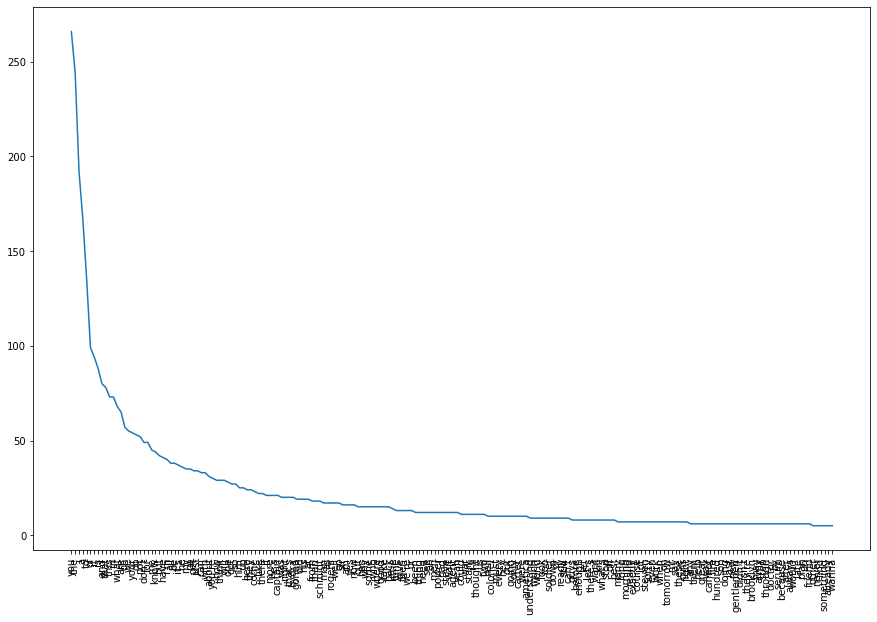

In [139]:
plt.figure(figsize=(15,10))
plt.plot(highest_200_df['word'], highest_200_df['rel_freq'])
plt.xticks(rotation = 90)
plt.show()

***

**Does the observed relative frequency of these words follow Zipf's law? Explain.**